In [2]:
import logging
from collections import defaultdict
from contextlib import ExitStack
from itertools import batched
from math import ceil
from pathlib import PurePath
from typing import Iterable, List

import brian2 as b2
import brian2hears as b2h
import dill
import graphviz
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sorcery import dict_of

from analyze import sound_analysis as SA
from analyze.graph import generate_flow_chart
from cochleas.consts import CFMAX, CFMIN
from cochleas.GammatoneCochlea import run_hrtf
from utils.custom_sounds import Tone
from utils.log import logger, tqdm

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (6, 3)

2025-01-09 13:54:46,067 [INFO ]  

>>>>> start execution


In [15]:
def avg_fire_rate_actv_neurons(x):
    active_neurons = set(x["senders"])
    return (len(x["times"]) / len(active_neurons)) if len(active_neurons) > 0 else 0

In [16]:
def flatten(items):
    """Yield items from any nested iterable.
    from https://stackoverflow.com/a/40857703
    """
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

In [19]:
def firing_neurons_distribution(x):
    "returns {neuron_id: num_spikes}.keys()"
    n2s = {id: 0 for id in x["global_ids"]}
    for sender in x["senders"]:
        n2s[sender] += 1
    return n2s.values()

In [22]:
def shift_senders(x, hist_logscale=False):
    "returns list of 'senders' with ids shifted to [0,num_neurons]. optionally ids are CFs"
    if hist_logscale:
        cf = b2h.erbspace(CFMIN, CFMAX, len(x["global_ids"])) / b2.Hz
        old2newid = {oldid: cf[i] for i, oldid in enumerate(x["global_ids"])}
    else:
        old2newid = {oldid: i for i, oldid in enumerate(x["global_ids"])}
    return [old2newid[i] for i in x["senders"]]

In [25]:
def draw_hist(
    ax, senders_renamed, angles, num_neurons, max_spikes_single_neuron, logscale=True
):
    """draws a low opacity horizontal histogram for each angle position

    includes a secondary y-axis, optionally logarithmic.
    if logscale, expects senders to be renamed to CFs
    """
    max_histogram_height = 0.25
    bin_count = 50
    alpha = 0.5
    if logscale:
        bins = b2h.erbspace(CFMIN, CFMAX, bin_count) / b2.Hz

        for j, angle in enumerate(angles):
            left_data = senders_renamed["L"][j]
            right_data = senders_renamed["R"][j]

            left_hist, _ = np.histogram(left_data, bins=bins)
            right_hist, _ = np.histogram(right_data, bins=bins)
            max_value = max(max(left_hist), max(right_hist))
            left_hist_normalized = left_hist / (max_value * max_histogram_height)
            right_hist_normalized = right_hist / (max_value * max_histogram_height)

            ax.barh(
                bins[:-1],
                -left_hist_normalized,
                height=np.diff(bins),  # bins have different sizes
                left=angle,
                color="C0",
                alpha=alpha,
                align="edge",
            )
            ax.barh(
                bins[:-1],
                right_hist_normalized,
                height=np.diff(bins),
                left=angle,
                color="C1",
                alpha=alpha,
                align="edge",
            )
        ax.set_yscale("log")
        ax.set_ylim(CFMIN, CFMAX)
        yticks = [20, 100, 500, 1000, 5000, 10000, 20000]
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{freq} Hz" for freq in yticks])
        ax.set_ylabel("approx CF (Hz)")
    else:
        bins = np.linspace(0, num_neurons, bin_count)

        for j, angle in enumerate(angles):
            left_data = senders_renamed["L"][j]
            right_data = senders_renamed["R"][j]

            left_hist, _ = np.histogram(left_data, bins=bins)
            right_hist, _ = np.histogram(right_data, bins=bins)
            left_hist_normalized = (
                left_hist / max_spikes_single_neuron * max_histogram_height
            )
            right_hist_normalized = (
                right_hist / max_spikes_single_neuron * max_histogram_height
            )

            ax.barh(
                bins[:-1],
                -left_hist_normalized,
                height=num_neurons / bin_count,
                left=angle,
                color="C0",
                alpha=alpha,
                align="edge",
            )
            ax.barh(
                bins[:-1],
                right_hist_normalized,
                height=num_neurons / bin_count,
                left=angle,
                color="C1",
                alpha=alpha,
                align="edge",
            )
        ax.set_ylabel("neuron id")
        ax.set_ylim(0, num_neurons)
    ax.yaxis.set_minor_locator(plt.NullLocator())  # remove minor ticks

In [62]:
def draw_rate_vs_angle(
    data,
    title,
    rate=True,
    hist_logscale=True,
    show_pops=["parrot_ANF", "GBC", "SBC", "LNTBC", "MNTBC", "LSO", "MSO"],
    ylim=None,
    show_hist=True,
):
    logger.debug(dict_of(title, show_pops, rate, hist_logscale))
    version = data["angle_to_rate"][0].get("version", None)
    angle_to_rate = data["angle_to_rate"]
    name = data["conf"]["model_desc"]["name"]
    sound_key = data["conf"]["sound_key"]
    duration = (
        data.get("simulation_time", data["basesound"].sound.duration / b2.ms) * b2.ms
    )
    logger.debug(f"simulation time={duration}")

    angles = list(angle_to_rate.keys())
    sides = ["L", "R"]

    with plt.ioff():
        fig, ax = plt.subplots(len(show_pops), figsize=(8, 2 * len(show_pops)))
    ax = list(flatten([ax]))

    for i, pop in tqdm(list(enumerate(show_pops)), desc="pop"):
        num_active = {
            side: [len(set(angle_to_rate[angle][side][pop])) for angle in angles]
            for side in sides
        }
        tot_spikes = {
            side: [
                len(angle_to_rate[angle][side][pop]["times"] / duration)
                for angle in angles
            ]
            for side in sides
        }
        active_neuron_rate = {
            side: [
                avg_fire_rate_actv_neurons(angle_to_rate[angle][side][pop])
                * (1 * b2.second)
                / duration
                for angle in angles
            ]
            for side in sides
        }
        distr = {
            side: [
                firing_neurons_distribution(angle_to_rate[angle][side][pop])
                for angle in angles
            ]
            for side in sides
        }
        plotted_rate = active_neuron_rate if rate else tot_spikes
        ax[i].plot(angles, plotted_rate["L"], 'o-', color = 'm')
        ax[i].set_title(pop)
        ax[i].plot(angles, plotted_rate["R"], 'o-', color = 'g')
        ax[i].set_ylabel("active neuron spikes/s [Hz]" if rate else "overall spikes/s")
        ax[i].set_ylim(ylim)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

        if show_hist:
            v = ax[i].twinx()
            v.grid(visible=False)  # or use linestyle='--'
            if version > 2:  # needed for global ids
                senders_renamed = {
                    side: [
                        shift_senders(angle_to_rate[angle][side][pop], hist_logscale)
                        for angle in angles
                    ]
                    for side in sides
                }
                max_spikes_single_neuron = max(flatten(distr.values()))
                draw_hist(
                    v,
                    senders_renamed,
                    angles,
                    num_neurons=len(angle_to_rate[0]["L"][pop]["global_ids"]),
                    max_spikes_single_neuron=max_spikes_single_neuron,
                    logscale=hist_logscale,
                )
        # _ = ax[i].legend(loc="lower right")

    plt.suptitle(title)
    plt.setp([ax], xticks=angles)
    [ax.set_xticklabels([f"{i}°" for i in angle_to_rate.keys()]) for ax in ax]

    plt.tight_layout()
    return fig


2025-01-09 16:28:02,968 [DEBUG]  {'title': 'All Populations', 'show_pops': ['parrot_ANF', 'GBC', 'SBC', 'LNTBC', 'MNTBC', 'LSO', 'MSO'], 'rate': False, 'hist_logscale': True}
2025-01-09 16:28:02,969 [DEBUG]  simulation time=200. ms


pop: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


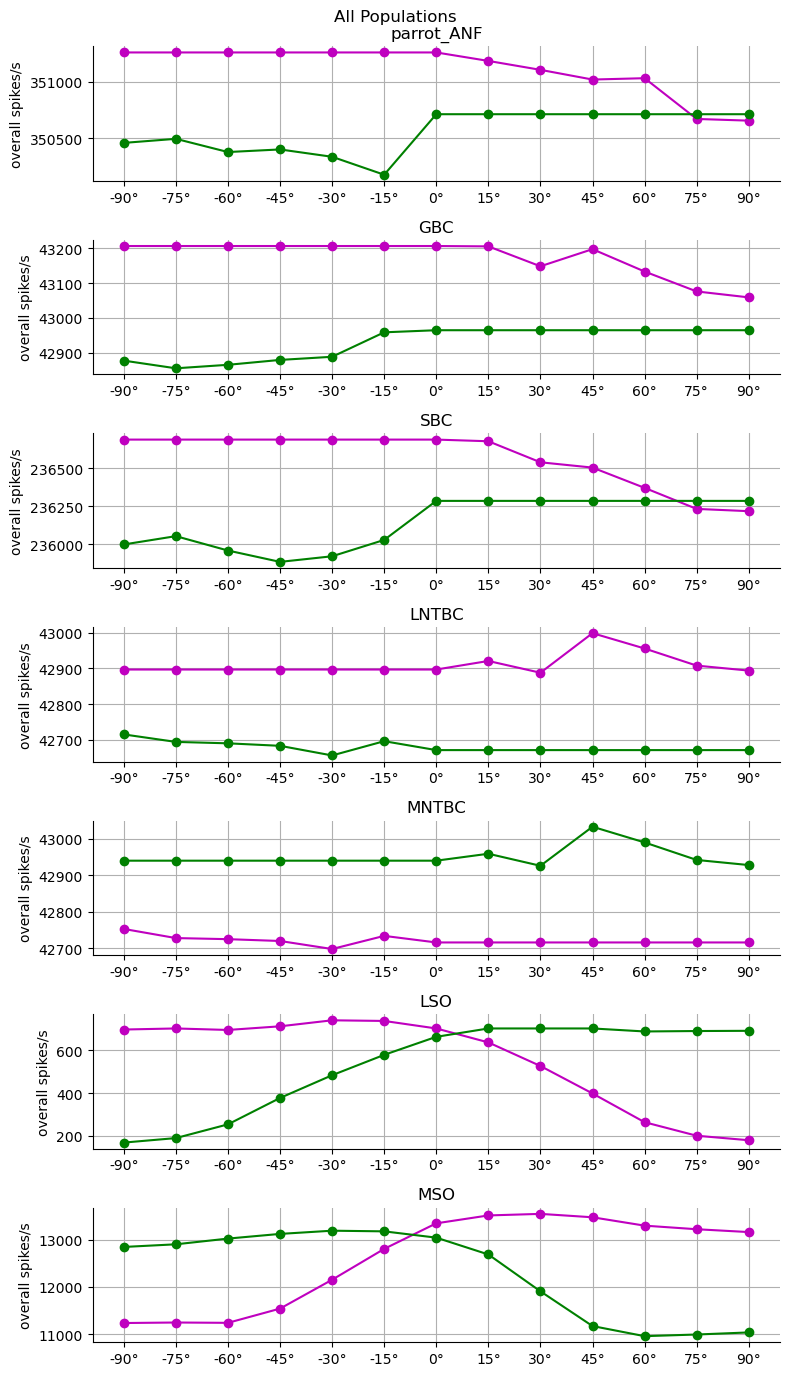

In [65]:
result_path = '/home/ubuntu/polithesis/results/000/withICC&TanCarney&Paolo_default/2025-01-07T12:43:24&tone_100.Hz_70dB&TanCarney&withICC&headless.pic'
with open(result_path, "rb") as f:
    res = dill.load(f, ignore=True)

draw_rate_vs_angle(
    res,
    "All Populations",
    rate=False,
    hist_logscale=True,
    show_pops= ["parrot_ANF", "GBC", "SBC", "LNTBC", "MNTBC", "LSO", "MSO"],
    show_hist=False
)